In [1]:

import iris
import iris.plot as iplt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import warnings
from eofs.iris import Eof
from eofs.examples import example_data_path
import iris.coord_categorisation
import datetime as dt
import iris.quickplot as qplt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import xarray as xr
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8,8),
                           subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.add_feature(LAND, facecolor='None')
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    XTEXT_SIZE =30
    YTEXT_SIZE =30
    gl.xlabel_style = {'size': XTEXT_SIZE, 'color': 'k'}
    gl.ylabel_style = {'size':YTEXT_SIZE, 'color': 'k', 'weight': 'normal'}

def geo_height_plots(day_index0,  data):
#requires you to have data_for_inst_loaded
    plt.clf
    #bbox = [lons.min(), lons.max(), lats.min(), lats.max()]
    bbox=[-90, 60, 0, 90]
    level = 10  # 10 meters temperature.
    lats = data.__getitem__('latitude').values
    lons = data.__getitem__('longitude').values
    x,y = lons,lats
    fig 
    for day in np.arange(day_index0,day_index1,1):
        plt.clf
        fig, ax = plt.subplots(1,5)
        fig, ax = make_map(bbox=bbox)
        index_list = list()
        list_of_blocked_lons =list ()
        data1 = data.to_array().data[0,4*(day-1),:,:]
        plt.scatter(list_of_blocked_lons,list_of_blocked_lats, zorder=1,marker = 'o',s=15,c='red')
                       
        cs = ax.pcolormesh(x, y, data1,cmap='viridis',zorder = -1)
        con = ax.contour(x,y,data1,colors ='w', levels = 7)
        ax.clabel(con,fontsize=9,inline = True)
        plt.title('Day '+ str(day), fontsize=30)
        cbar = fig.colorbar(cs, orientation='vertical',extend='both')
        cbar.set_label('Geopotential height /m', fontsize =15)
        cbar.ax.tick_params(labelsize=10)
        print(index_list)
        plt.show()

In [3]:


def plot_geo_heights(year,day_index):
    data = xr.open_dataset(f'data/{year}djf_final.nc')['Z'].isel(p=15) # need to be anomaly
    result = data - data.mean("t")
    result = result/ 9.80665
    
    #testing wind
    wind_ds = xr.open_dataset('wind_remaped_ERA5_500hpa.nc').sel(time=data.__getitem__('t')[4*(day_index)],method = 'nearest')
    plt.clf()
    fig, ax = plt.subplots(2,5, figsize=(25,12), subplot_kw=dict(projection=ccrs.PlateCarree()))
    bbox=[-10, 40, 30, 75]
    LAND = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                    edgecolor='face',
                                    facecolor=cfeature.COLORS['land'])
    lats = result.__getitem__('lat').values
    lons = result.__getitem__('lon').values
    x,y = lons,lats
    bbox_wind = [-10,40,30,70]
        
    # get max and min of arrays 
    maxi = 0 
    mini = 0
    for k in range(5):
        test_max = np.amax(result[4*(k+day_index),:,:].values)
        test_min = np.amin(result[4*(k+day_index),:,:].values)
        if test_max > maxi:
            maxi = test_max
        if test_min < mini:
            mini = test_min

    # defining contour levels
    levs = np.arange(-400,400,40)
    for k in range(5):
        ax[0,k].set_extent(bbox)
        ax[0,k].add_feature(LAND, facecolor='None')
        ax[0,k].coastlines(resolution='50m')
        gl = ax[0,k].gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        XTEXT_SIZE =10
        YTEXT_SIZE =10
        gl.ylabel_style = {'size':YTEXT_SIZE, 'color': 'k', 'weight': 'normal'}
        gl.xlabel_style = {'size': XTEXT_SIZE, 'color': 'k'}
        data1 = result[4*(k+day_index),:,:].values
        cs = ax[0,k].pcolormesh(x, y, data1,cmap='viridis',zorder = -1,vmax=maxi,vmin=mini)
        con = ax[0,k].contour(x,y,data1,colors ='w', levels = levs)
        ax[0,k].clabel(con)
        ax[0,k].set_title(f'Day {k+1}',fontsize = 14)
        
        #wind plot 
        wind_ds = xr.open_dataset('wind_remaped_ERA5_500hpa.nc').sel(time=data.__getitem__('t')[4*(day_index+k)],method = 'nearest')
        x_wind,y_wind = wind_ds.__getitem__('lat').values[2:],wind_ds.__getitem__('lon').values
        ax[1,k].set_extent(bbox_wind)
        ax[1,k].add_feature(LAND, facecolor='None')
        ax[1,k].coastlines(resolution='50m')
        gl = ax[1,k].gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.ylabel_style = {'size':YTEXT_SIZE, 'color': 'k', 'weight': 'normal'}
        gl.xlabel_style = {'size': XTEXT_SIZE, 'color': 'k'}
        ax[0,k].quiver(y_wind,x_wind,wind_ds['v'].values[2:,:],wind_ds['u'].values[2:,:],pivot = 'middle')
        
        VPV = xr.open_dataset('norm_VPV_djf_ERA5_EUR.nc').sel(time=data.__getitem__('t')[4*(day_index+k)],method = 'nearest')['pv']
        VPVx,VPVy = VPV.__getitem__('longitude'), VPV.__getitem__('latitude')
        cs1 = ax[1,k].pcolormesh(VPVx, VPVy, VPV.values,cmap='PiYG',zorder = -1)
        
        #wind second plot
        wind_ds_10m = xr.open_dataset('wind_10m_remaped_ERA5.nc').sel(time=data.__getitem__('t')[4*(day_index+k)],method = 'nearest')
        ax[1,k].quiver(y_wind,x_wind,wind_ds_10m['v10'].values[1:12,:],wind_ds_10m['u10'].values[1:12,:],pivot = 'middle')
        
    cbar = fig.colorbar(cs,extend='both',location = 'right',ax = ax[0,:],shrink =0.5)
    cbar1 = fig.colorbar(cs1,extend='both',location = 'right',ax = ax[1,:],shrink =0.5)
    cbar.set_label('Geopotential height Anomaly /m', fontsize =10)
    cbar1.set_label('Normalised Vertically Averaged PV', fontsize = 10)
    cbar.ax.tick_params(labelsize=10)
    fig.suptitle('Geopotential Height with wind on 500 hPa, and VPV with 10m wind', fontsize=30, x=0.45)

In [4]:
xr.open_dataset('norm_VPV_djf_ERA5_EUR.nc')['pv']

<xarray.DataArray 'pv' (time: 3700, latitude: 181, longitude: 201)>
[134609700 values with dtype=float32]
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
  * longitude   (longitude) float32 -10.0 -9.75 -9.5 -9.25 ... 39.5 39.75 40.0
  * latitude    (latitude) float32 75.0 74.75 74.5 74.25 ... 30.5 30.25 30.0
    year_month  (time) object ...

In [5]:
wind_ds_10m = xr.open_dataset('wind_10m_remaped_ERA5.nc').isel(time=0)
print(wind_ds_10m)
xr.open_dataset('wind_remaped_ERA5_500hpa.nc')

<xarray.Dataset>
Dimensions:    (bnds: 2, lon: 11, lat: 13)
Coordinates:
    time       datetime64[ns] 1979-01-01
  * lon        (lon) float64 -10.0 -5.0 0.0 5.0 10.0 ... 25.0 30.0 35.0 40.0
  * lat        (lat) float64 15.0 20.0 25.0 30.0 35.0 ... 60.0 65.0 70.0 75.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (bnds) datetime64[ns] ...
    u10        (lat, lon) float32 ...
    v10        (lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Jan 25 15:52:30 2022: cdo -remapbil,~/Atmospheric_block...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


<xarray.Dataset>
Dimensions:  (time: 3791, lon: 11, lat: 13)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2020-12-31
  * lon      (lon) float64 -10.0 -5.0 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0
  * lat      (lat) float64 15.0 20.0 25.0 30.0 35.0 ... 55.0 60.0 65.0 70.0 75.0
Data variables:
    u        (time, lat, lon) float32 ...
    v        (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Jan 24 19:07:54 2022: cdo -remapbil,~/Atmospheric_block...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

/opt/jaspy/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/jaspy/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/opt/jaspy/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/jaspy/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/opt/jas

<Figure size 432x288 with 0 Axes>

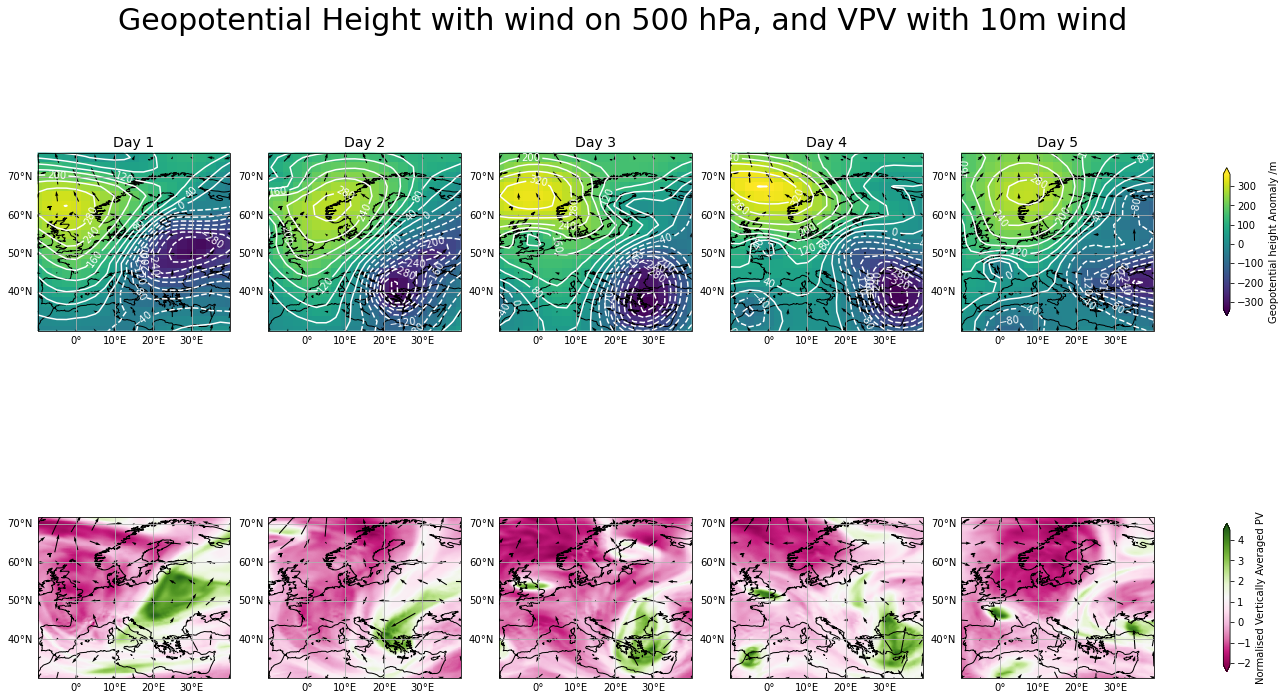

In [8]:
with warnings.catch_warnings():
    plot_geo_heights(2004,73)
    

# Notes 
1. persistent obstruction of the normal west-to-east flow pattern,
2. pronounced meridional flow in the upper levels, and
3. anticyclonic circulation at high latitudes accompanying cyclonic circulation at low latitudes.